# Exploratory Data Analysis (EDA)
## Credit Risk Modeling with Alternative Data (Xente Dataset)


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


# load the data set and sanity check

In [16]:
data_path = "../data/raw/data.csv"
df = pd.read_csv(data_path)
print(df.head())
df.info()


         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Value  TransactionStart

# Convert TransactionStartTime to datetime

In [17]:
df["TransactionStartTime"] = pd.to_datetime(df["TransactionStartTime"])
df["TransactionStartTime"].head()

0   2018-11-15 02:18:49+00:00
1   2018-11-15 02:19:08+00:00
2   2018-11-15 02:44:21+00:00
3   2018-11-15 03:32:55+00:00
4   2018-11-15 03:34:21+00:00
Name: TransactionStartTime, dtype: datetime64[ns, UTC]

# Summary statistics (numerical)

In [18]:
df.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


# Transaction value distribution

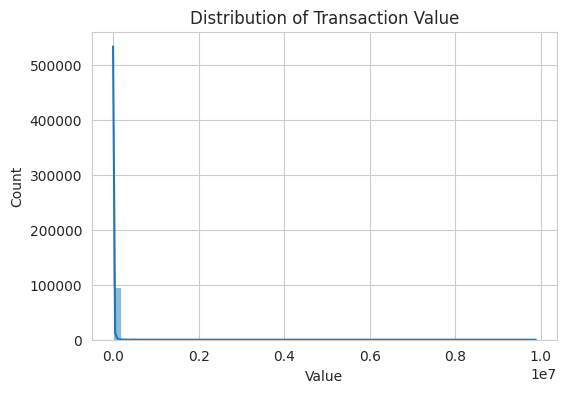

In [19]:
plt.figure(figsize=(6,4))
sns.histplot(df["Value"], bins=50, kde=True)
plt.title("Distribution of Transaction Value")
plt.show()


# Channel usage

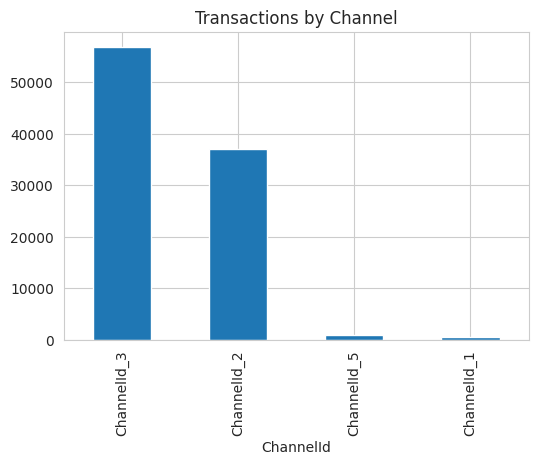

In [20]:
df["ChannelId"].value_counts()

plt.figure(figsize=(6,4))
df["ChannelId"].value_counts().plot(kind="bar")
plt.title("Transactions by Channel")
plt.show()


# Product category distribution

In [21]:
df["ProductCategory"].value_counts().head(10)


ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
ticket                  216
movies                  175
transport                25
other                     2
Name: count, dtype: int64

# Fraud flag check (context only)

In [22]:
df["FraudResult"].value_counts(normalize=True)


FraudResult
0    0.997982
1    0.002018
Name: proportion, dtype: float64

# Correlation matrix

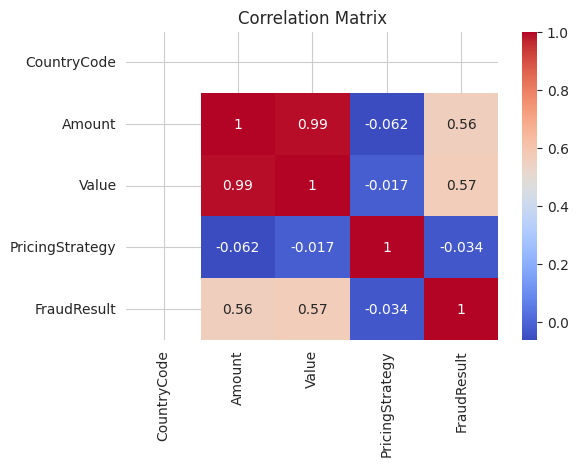

In [23]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(6,4))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


# Outlier detection

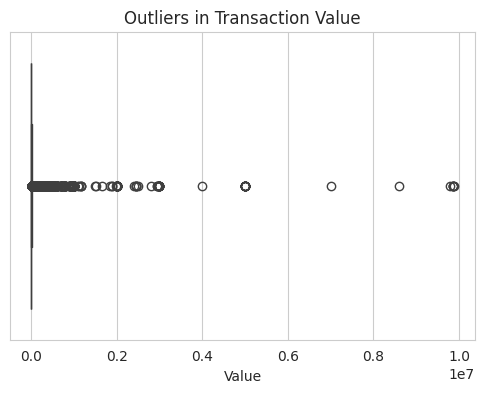

In [24]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Value"])
plt.title("Outliers in Transaction Value")
plt.show()


# Task 4 - Proxy Target Variable Engineering 

## Define a Snapshot Date

In [25]:
snapshot_date = df["TransactionStartTime"].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2019-02-14 10:01:28+0000', tz='UTC')

# Build the RFM Table

In [26]:
rfm = (
    df.groupby("CustomerId")
    .agg(
        Recency=("TransactionStartTime", lambda x: (snapshot_date - x.max()).days),
        Frequency=("TransactionId", "count"),
        Monetary=("Value", "sum"),
    )
    .reset_index()
)

rfm.head()


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,10000
1,CustomerId_10,84,1,10000
2,CustomerId_1001,90,5,30400
3,CustomerId_1002,26,11,4775
4,CustomerId_1003,12,6,32000


# Inspect RFM Distributions

## Recency

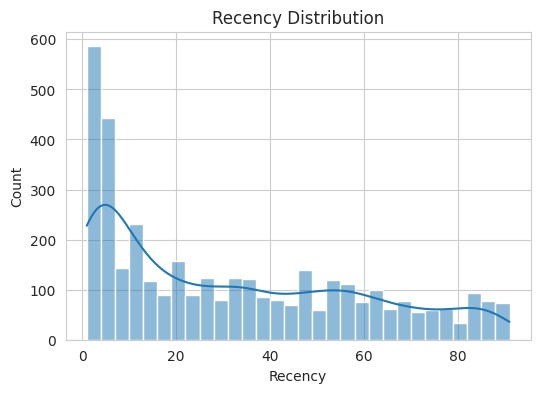

In [27]:
plt.figure(figsize=(6,4))
sns.histplot(rfm["Recency"], bins=30, kde=True)
plt.title("Recency Distribution")
plt.show()


## Frequency

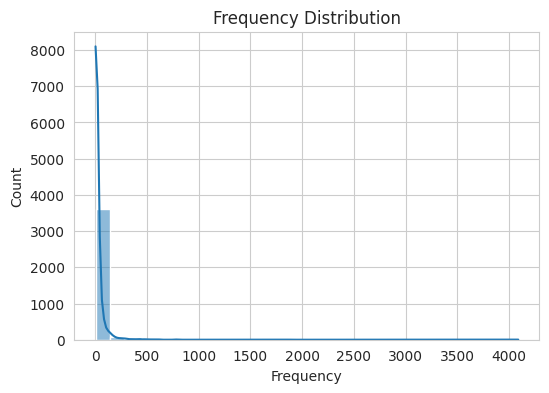

In [28]:
plt.figure(figsize=(6,4))
sns.histplot(rfm["Frequency"], bins=30, kde=True)
plt.title("Frequency Distribution")
plt.show()


## Monetary

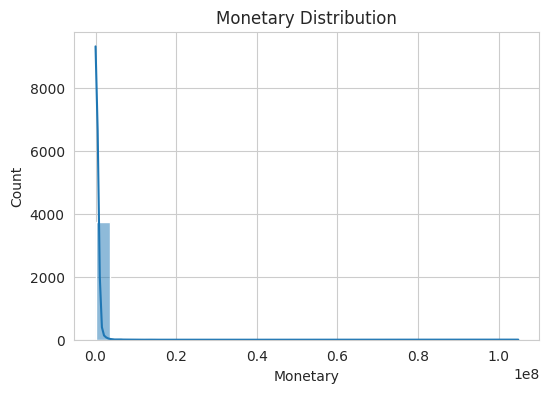

In [29]:
plt.figure(figsize=(6,4))
sns.histplot(rfm["Monetary"], bins=30, kde=True)
plt.title("Monetary Distribution")
plt.show()


# Scale RFM Features

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm[["Recency", "Frequency", "Monetary"]]
)

rfm_scaled[:5]


array([[ 1.93760472, -0.25345907, -0.08952358],
       [ 1.93760472, -0.25345907, -0.08952358],
       [ 2.15888193, -0.21218649, -0.08201119],
       [-0.20140839, -0.15027763, -0.09144771],
       [-0.7177219 , -0.20186835, -0.08142198]])

# KMeans Clustering (3 Clusters)

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

rfm["cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,CustomerId,Recency,Frequency,Monetary,cluster
0,CustomerId_1,84,1,10000,0
1,CustomerId_10,84,1,10000,0
2,CustomerId_1001,90,5,30400,0
3,CustomerId_1002,26,11,4775,1
4,CustomerId_1003,12,6,32000,1


# Interpret the Clusters

In [35]:
rfm.groupby("cluster")[["Recency", "Frequency", "Monetary"]].mean()


,Recency,Frequency,Monetary
cluster,,,
0,61.877279,7.720196,8.973793e+04
1,12.715398,34.703720,2.247565e+05
2,23.250000,1104.500000,7.487659e+07


# Visualize Clusters

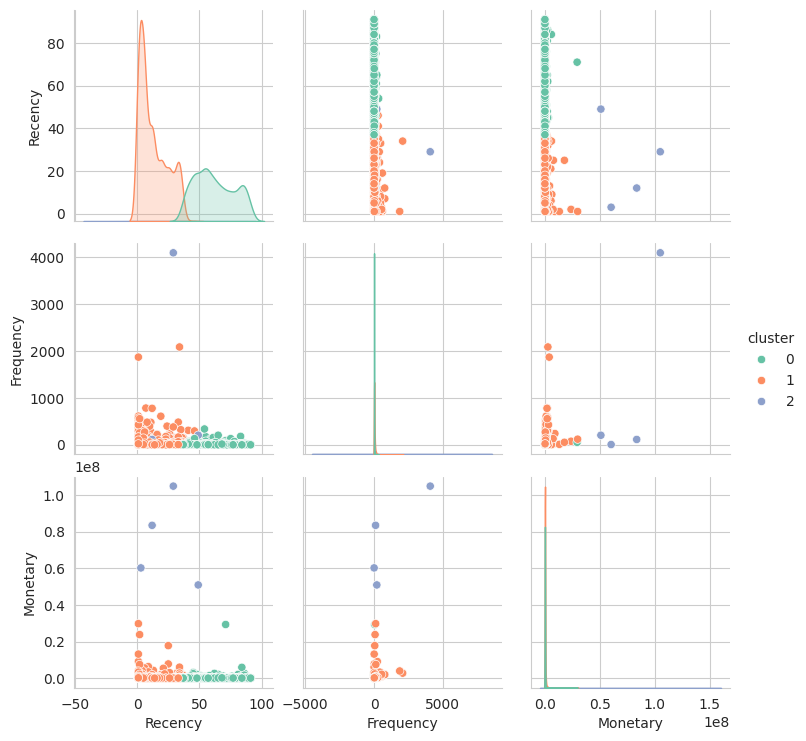

In [36]:
sns.pairplot(
    rfm,
    vars=["Recency", "Frequency", "Monetary"],
    hue="cluster",
    palette="Set2"
)
plt.show()
